<a href="https://colab.research.google.com/github/Ziad-o-Yusef/-Medical-Cost-Personal/blob/main/17_DCGANs_Brain_MRI_Creation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os 
import tensorflow as tf
import math 
from tqdm import tqdm 
from google.colab import drive 

In [2]:
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle_MyAPI'
! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Mounted at /content/drive
 60% 9.00M/15.1M [00:00<00:00, 36.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 57.0MB/s]


In [8]:
%mkdir /content/dataset

In [9]:
%cd /content/dataset

/content/dataset


In [ ]:
! unzip /content/brain-mri-images-for-brain-tumor-detection.zip

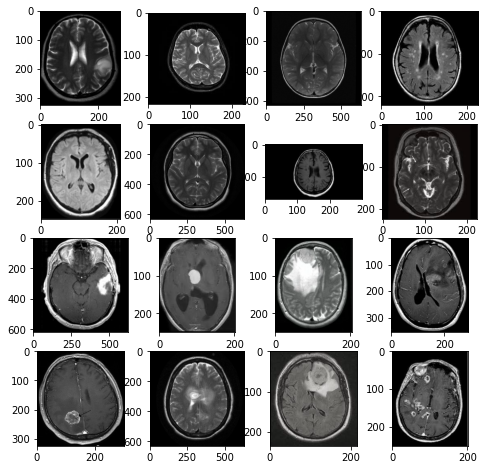

In [11]:
dir = '/content/dataset'
dirs = os.listdir(dir)
imshow_dirs = []
for i in dirs : 
    step = os.listdir(dir+ '/'+ i)
    for x in range(8):
        try : 
          imshow_dirs.append(dir+ '/' + i + '/' + step[x])
        except : 
          continue
fig, ax = plt.subplots(4,4,figsize=(8,8))
for n in range(4):
    for m in range(4):
        path =imshow_dirs[m + 4*n]
        image = cv2.imread(str(path))
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [12]:
cv2.imread(imshow_dirs[0]).shape


(326, 276, 3)

In [59]:
X = []
Y = []
dirs = ['/content/dataset/no','/content/dataset/yes']
for i in dirs:
    path = i
    for x in os.listdir(path):
        img = cv2.imread(path + '/'+ x)
        img = cv2.resize(img,(128, 128), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(128,128,1)
        X.append(img)
        Y.append(i)
X = np.array(X)
Y = np.array(Y)
X.shape , Y.shape

((253, 128, 128, 1), (253,))

In [29]:
X = (X.astype(np.float32) - 127.5)/127.5

In [63]:
np.random.seed(42)
tf.random.set_seed(42)
random_dim = 100
image_dim = 128*128*1

In [16]:
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

In [93]:
def get_generator():    
    generator = Sequential()
    generator.add(Dense(64* 64 * 128, input_shape=[random_dim]))
    generator.add(Reshape([64, 64, 128]))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(64, kernel_size=2, strides=2, padding="same",
                                    activation="relu"))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(1, kernel_size=5, strides=1, padding="same",
                                    activation="tanh"))
    generator.compile(loss="binary_crossentropy", optimizer="adam")
    return generator
get_generator().summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 524288)            52953088  
                                                                 
 reshape_29 (Reshape)        (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_92 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_91 (Conv2D  (None, 128, 128, 64)     32832     
 Transpose)                                                      
                                                                 
 batch_normalization_93 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                     

In [94]:
def get_discriminator():    
  discriminator = Sequential()
  discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                          activation=LeakyReLU(0.3),
                          input_shape=[128,128,1]))
  discriminator.add(Dropout(0.5))
  discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                          activation=LeakyReLU(0.3)))
  discriminator.add(Dropout(0.5))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation="sigmoid"))
  discriminator.compile(loss="binary_crossentropy", optimizer="adam")
  return discriminator

In [77]:
def get_gan_network(disc,gen):
  disc.trainable = False
  gan_input = tf.keras.layers.Input(shape=(random_dim))
  x = gen(gan_input)
  gan_output = disc(x)
  gan = tf.keras.models.Model(inputs=gan_input, outputs=gan_output)
  gan.compile(loss='binary_crossentropy', optimizer='adam')
  return gan

In [95]:
def training(epochs = 5, batch_size = 128):

  batch_count = X.shape[0] / batch_size

  generator = get_generator()
  discriminator = get_discriminator()
  gan = get_gan_network(discriminator,generator)

  for epoch in range(1, epochs+1):
    print('-'*25, 'Epoch %d' % epoch, '-'*25)

    for _ in tqdm(range(int(batch_count))):
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      image_batch = X[np.random.randint(0, X.shape[0], size=batch_size)]

      generated_images = generator.predict(noise)
      concat = np.concatenate([image_batch, generated_images])

      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9

      discriminator.trainable = True
      discriminator.train_on_batch(concat, y_dis)

      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_gen)
      if epoch == 1 or epoch % 20 == 0:
        plot_generated_images(epoch, generator)

In [96]:
def plot_generated_images(epoch, generator, examples=36, dim=(6, 6), figsize=(6, 6)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, int(math.sqrt(image_dim)),int(math.sqrt(image_dim)))
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
training(epochs=3000)